In [1]:
import os
from tqdm import tqdm
import cv2
import multiprocessing
from metadata import Metadata
import matplotlib.pyplot as plt
from dredFISH.Processing.Section import *
import numpy as np
import torch
from scipy.ndimage import gaussian_filter,percentile_filter,median_filter,minimum_filter
dataset_path = '/orangedata/Images2024/Zach/MouseBrainAtlas/WTM02_3.1.A_2.3.B_3.3.D_1.2.E_2024Apr01'
image_metadata = Metadata(dataset_path)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [76]:
sorted([i for i in image_metadata.acqnames if 'ybe23' in i])

['Hybe23_229', 'Hybe23_230', 'Hybe23_231', 'Hybe23_232', 'Hybe23_233']

In [77]:
sorted([i for i in image_metadata.acqnames if 'rip23' in i])

['Strip23_225', 'Strip23_226', 'Strip23_227', 'Strip23_228']

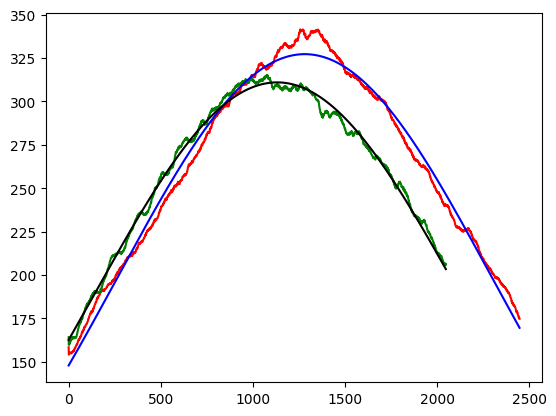

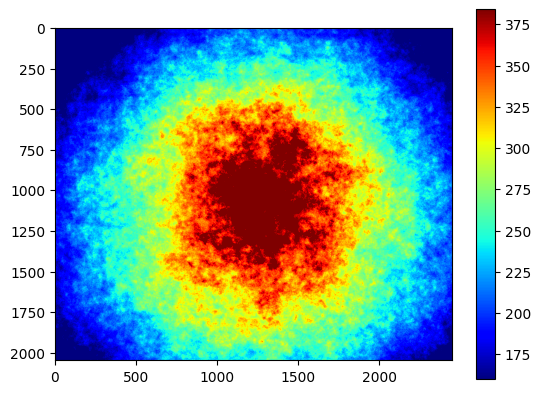

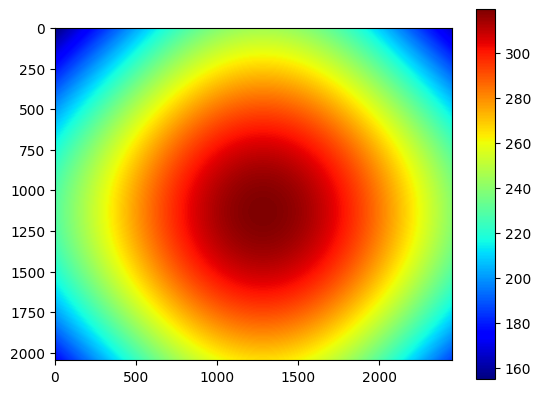

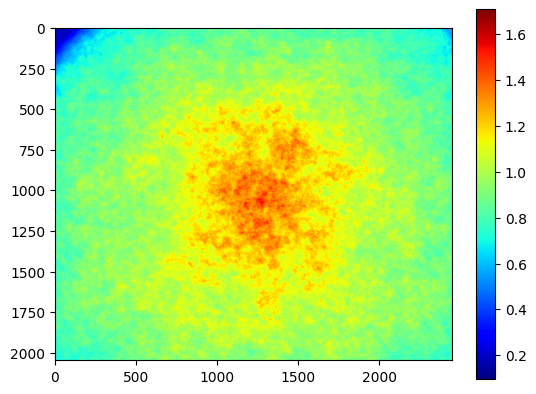

In [16]:
def generate_FF(image_metadata,acq,channel,posnames=[],bkg_acq='',parameters={},verbose=False):
    """
    generate_FF Generate flat field to correct uneven illumination

    :param image_metadata: Data Loader Class
    :type image_metadata: Metadata Class
    :param acq: name of acquisition
    :type acq: str
    :param channel: name of channel
    :type channel: str
    :return: flat field image
    :rtype: np.array
    """
    if 'mask' in channel:
        return ''
    else:
        if len(posnames)==0:
            posnames = image_metadata.image_table[image_metadata.image_table.acq==acq].Position.unique()
        # posnames = posnames[0:10] 
        FF = []
        if verbose:
            iterable = tqdm(posnames,desc=str(datetime.now().strftime("%Y %B %d %H:%M:%S"))+' Generating FlatField '+acq+' '+channel)
        else:
            iterable = posnames

        """ Multiprocess to speed up break up iterable into n iterables and run in parallel"""
        good_pos = 0
        # nuc_thresh = 1000
        for posname in iterable:
            if good_pos>parameters['n_FF_pos']:
                break
            try:
                # nuc = image_metadata.stkread(Position=posname,Channel='DeepBlue',acq=acq)
                # if np.sum(nuc>nuc_thresh)>(nuc.shape[0]*nuc.shape[1]*0.25):
                #     # print(np.mean(nuc),np.min(nuc),np.std(nuc),posname,good_pos)
                #     continue
                # print('Good',np.mean(nuc),np.min(nuc),np.std(nuc),posname,good_pos,'Good')
                good_pos+=1
                img = image_metadata.stkread(Position=posname,Channel=channel,acq=acq).min(2).astype(float)
                img = median_filter(img,2)
                img = torch.tensor(img)
                if bkg_acq!='':
                    bkg = image_metadata.stkread(Position=posname,Channel=channel,acq=bkg_acq).min(2).astype(float)
                    bkg = median_filter(bkg,2)
                    bkg = torch.tensor(bkg)
                    img = img-bkg
                # if parameters['clip_FF']:
                #     mu = np.percentile(img.numpy().ravel(),50)
                #     std = torch.std(img.ravel(),50)
                #     img = torch.clip(img,(mu-3*std),(mu+3*std))
                # img = img/torch.median(img)
                FF.append(img)
            except Exception as e:
                print(posname,acq,bkg_acq)
                print(e)
                continue
        FF = torch.dstack(FF)
        constant = torch.min(FF,dim=2).values # There may be a more robust way 
        if parameters['use_constant']:
            if parameters['fit_constant']:
                if parameters['post_strip_FF']: # assume a flat constant increase or decrease in signal
                    constant = np.ones_like(constant)*np.percentile(constant.ravel(),50)
                else:
                    x = gaussian_filter(np.percentile(median_filter(constant,5),50,axis=0),1)
                    y = gaussian_filter(np.percentile(median_filter(constant,5),50,axis=1),1)
                    from scipy.optimize import curve_fit
                    def gaussian(x, amplitude, mean, stddev):
                        return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)
                    x_data = np.arange(x.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, x, p0=[1, np.mean(x_data), np.std(x_data)])
                    x = gaussian(x_data, *popt)
                    x_data = np.arange(y.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, y, p0=[1, np.mean(x_data), np.std(x_data)])
                    y = gaussian(x_data, *popt)
                    constant = ((np.ones_like(constant)*x)+(np.ones_like(constant).T*y).T)/2
            else:
                constant = gaussian_filter(constant,50,mode='nearest')  # causes issues with corners

            if parameters['clip_constant']:
                vmin,vmid,vmax = np.percentile(constant[np.isnan(constant)==False],[0.1,50,99.9]) 
                # Maybe add median filter to FF 
                constant[constant<vmin] = vmin
                constant[constant>vmax] = vmax
        else:
            constant = constant*0

        FF = FF-constant[:,:,None]
        # if parameters['clip_FF']:
        #     vmin = torch.median(torch.quantile(FF,0.25,axis=2))
        #     vmid = torch.median(torch.quantile(FF,0.5,axis=2))
        #     vmax = torch.median(torch.quantile(FF,0.75,axis=2))
        #     std = (vmax-vmin)
        #     print(vmid-3*std)
        #     print(vmid+3*std)
        #     print(vmid,vmax,vmin,std)
        #     FF = torch.clip(FF,min=vmid-3*std,max=vmid+3*std)
        FF = torch.quantile(FF,0.5,axis=2).numpy()
        fit_FF = FF.copy()
        raw_x = np.nan
        raw_y = np.nan
        x = np.nan
        y = np.nan
        if parameters['use_FF']:
            if parameters['fit_FF']:
                x = np.mean(FF,axis=0)
                y = np.mean(FF,axis=1)
                raw_x = x.copy()
                raw_y = y.copy()
                plt.plot(range(x.shape[0]),x,c='r')
                plt.plot(range(y.shape[0]),y,c='g')
                try:
                    from scipy.optimize import curve_fit
                    def gaussian(x, amplitude, mean, stddev):
                        return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)
                    x_data = np.arange(x.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, x, p0=[1, np.mean(x_data), np.std(x_data)])
                    x = gaussian(x_data, *popt)
                    x_data = np.arange(y.shape[0])
                    popt, _ = curve_fit(gaussian, x_data, y, p0=[1, np.mean(x_data), np.std(x_data)])
                    y = gaussian(x_data, *popt)
                    plt.plot(range(x.shape[0]),x,c='b')
                    plt.plot(range(y.shape[0]),y,c='k')
                    fit_FF = ((np.ones_like(FF)*x)+(np.ones_like(FF).T*y).T)/2
                except Exception as e:
                    print(e)
                plt.show()
            else:
                fit_FF = gaussian_filter(FF,5,mode='reflect')
            # vmin,vmid,vmax = np.percentile(FF[np.isnan(FF)==False],[0.1,50,99.9]) 
            # if parameters['clip_FF']:
            #     # vmin,vmid,vmax = np.percentile(FF[np.isnan(FF)==False],[0.1,50,99.9]) 
            #     # Maybe add median filter to FF 
            #     FF[FF<vmin] = vmin
            #     FF[FF>vmax] = vmax
            #     FF[FF==0] = vmid
            # FF = vmid/FF
        else:
            FF = (FF*0)+1
        return fit_FF,FF,constant,raw_x,raw_y,x,y
    
parameters = {}
parameters['use_constant'] = False
parameters['fit_constant'] = False
parameters['post_strip_FF'] = True
parameters['clip_constant'] = False
parameters['use_FF'] = True
parameters['fit_FF'] = True
parameters['clip_FF'] = False
parameters['n_FF_pos'] = 300

acq = 'Hybe21_70'
bkg_acq = 'Strip21_66'
channel = 'FarRed'

fit_FF,FF,constant,raw_x,raw_y,x,y = generate_FF(image_metadata,acq,channel,posnames=[],bkg_acq=bkg_acq,parameters=parameters,verbose=True)
plt.imshow(FF,vmin=np.percentile(FF,5),vmax=np.percentile(FF,95),cmap='jet')
plt.colorbar()
plt.show()
plt.imshow(fit_FF,cmap='jet')
plt.colorbar()
plt.show()
plt.imshow(FF/fit_FF,cmap='jet')
plt.colorbar()
plt.show()

In [39]:
posnames = image_metadata.image_table[image_metadata.image_table.acq==acq].Position.unique()
posnames[30]

'WellB-Section1-Pos612_16_12'

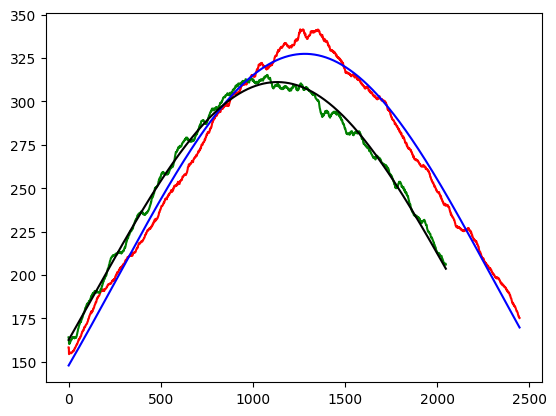

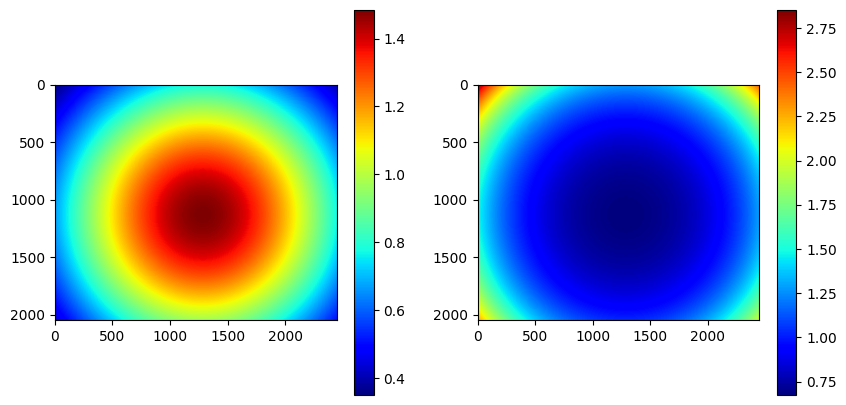

Hybe21_70 Strip21_66


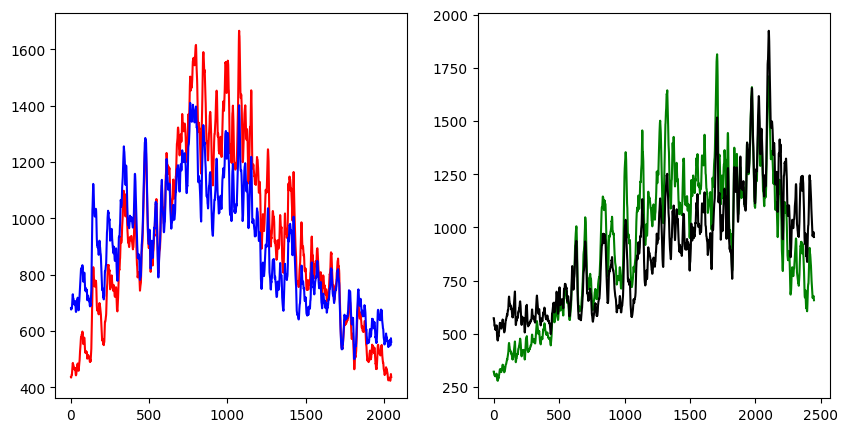

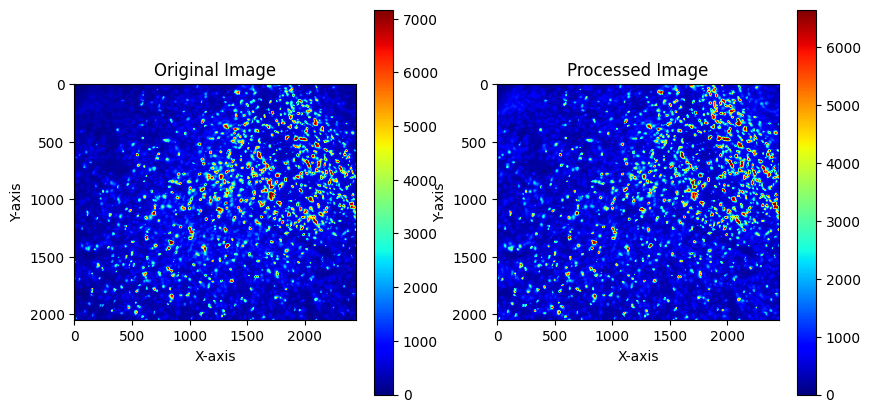

Hybe23_231 Strip23_226


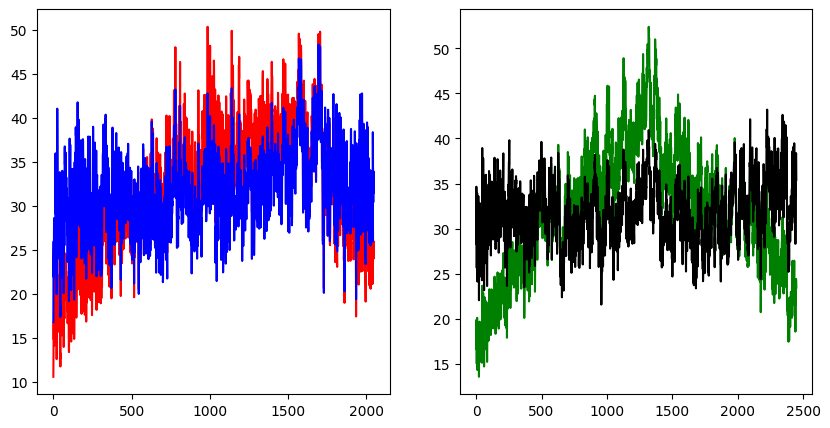

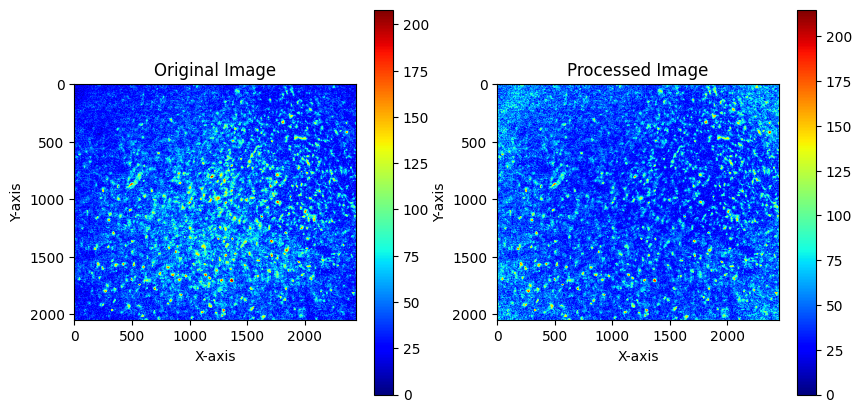

In [89]:
x = median_filter(np.mean(FF,axis=0),2)
y = median_filter(np.mean(FF,axis=1),2)
raw_x = x.copy()
raw_y = y.copy()
plt.plot(range(x.shape[0]),x,c='r')
plt.plot(range(y.shape[0]),y,c='g')
try:
    from scipy.optimize import curve_fit
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) / 2 / stddev)**2)
    x_data = np.arange(x.shape[0])
    popt, _ = curve_fit(gaussian, x_data, x, p0=[1, np.mean(x_data), np.std(x_data)])
    x = gaussian(x_data, *popt)
    x_data = np.arange(y.shape[0])
    popt, _ = curve_fit(gaussian, x_data, y, p0=[1, np.mean(x_data), np.std(x_data)])
    y = gaussian(x_data, *popt)
    plt.plot(range(x.shape[0]),x,c='b')
    plt.plot(range(y.shape[0]),y,c='k')
    fit_FF = ((np.ones_like(FF)*x)*(np.ones_like(FF).T*y).T)
    fit_FF = fit_FF/np.median(fit_FF)
except Exception as e:
    print(e)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im = axs[0].imshow(fit_FF,cmap='jet')
plt.colorbar(im,ax=axs[0])
im=axs[1].imshow(1/fit_FF,cmap='jet')
plt.colorbar(im,ax=axs[1])
plt.show()

for acq,bkg_acq in [['Hybe21_70','Strip21_66'],['Hybe23_231','Strip23_226']]:
    print(acq,bkg_acq)
    img = image_metadata.stkread(Position=posnames[30],Channel=channel,acq=acq).min(2).astype(float)
    img = median_filter(img,2)
    bkg = image_metadata.stkread(Position=posnames[30],Channel=channel,acq=bkg_acq).min(2).astype(float)
    bkg = median_filter(bkg,2)
    img = img-bkg

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(range(img.shape[0]), np.mean(img, axis=1), c='r')
    axs[0].plot(range(img.shape[0]), np.mean(np.median(fit_FF) * img / fit_FF, axis=1), c='b')

    axs[1].plot(range(img.shape[1]), np.mean(img, axis=0), c='g')
    axs[1].plot(range(img.shape[1]), np.mean(np.median(fit_FF) * img / fit_FF, axis=0), c='k')

    plt.show()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    vmin,vmax = np.percentile(img.ravel(),[1,99])
    im = axs[0].imshow(np.clip(img,0,vmax),cmap='jet')
    axs[0].set_title('Original Image')
    axs[0].set_xlabel('X-axis')
    axs[0].set_ylabel('Y-axis')
    plt.colorbar(im, ax=axs[0])  # Adding colorbar to the plot

    img = np.median(fit_FF)*img/fit_FF
    vmin,vmax = np.percentile(img.ravel(),[1,99])
    im = axs[1].imshow(np.clip(img,0,vmax),cmap='jet')
    axs[1].set_title('Processed Image')
    axs[1].set_xlabel('X-axis')
    axs[1].set_ylabel('Y-axis')
    plt.colorbar(im, ax=axs[1]) 

    plt.show()



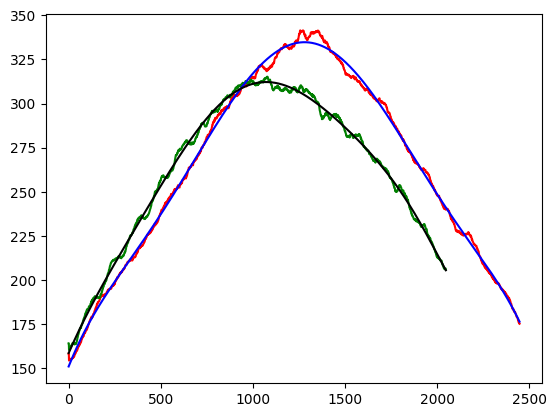

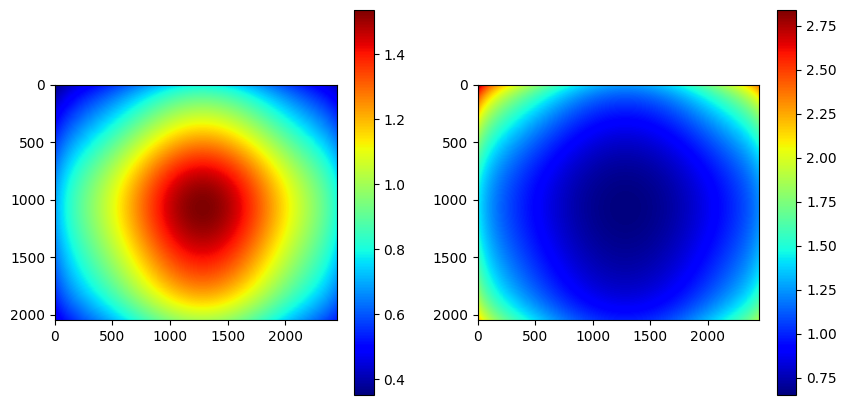

Hybe21_70 Strip21_66


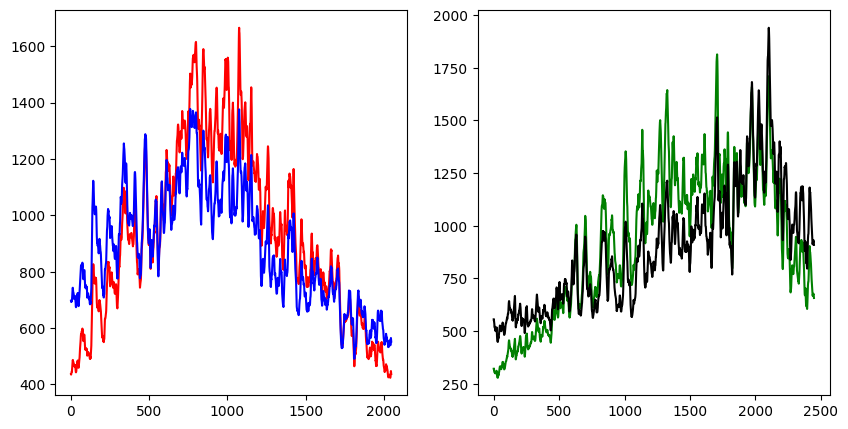

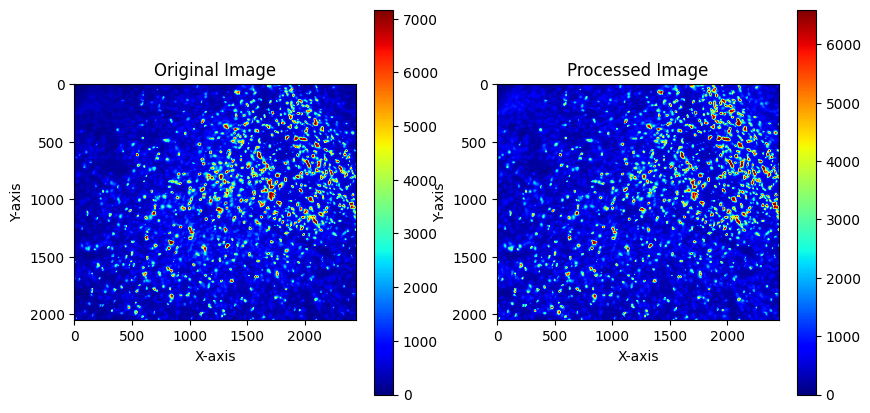

Hybe23_231 Strip23_226


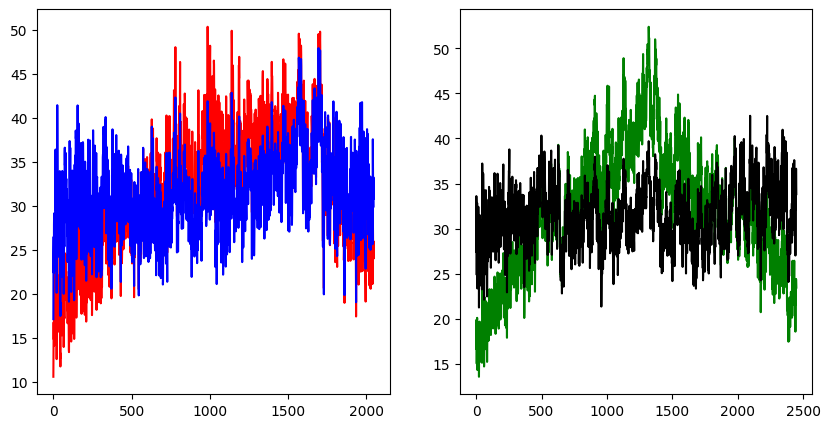

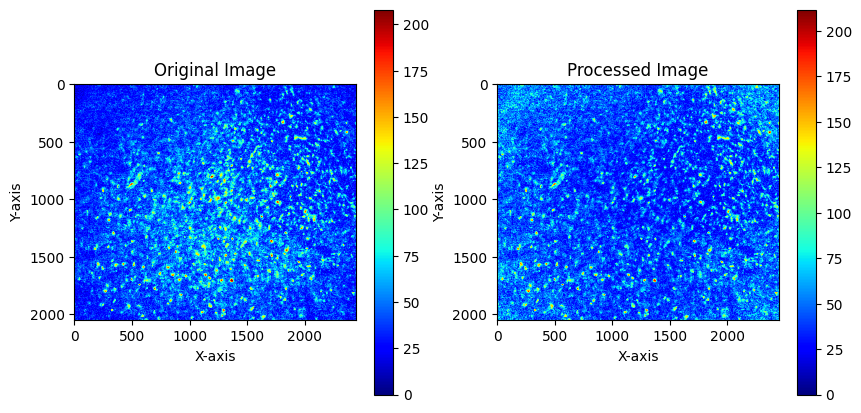

In [90]:
x = median_filter(np.mean(FF,axis=0),2)
y = median_filter(np.mean(FF,axis=1),2)
raw_x = x.copy()
raw_y = y.copy()
plt.plot(range(x.shape[0]),x,c='r')
plt.plot(range(y.shape[0]),y,c='g')
x_sum = x.sum()
y_sum = y.sum()
try:
    x = np.poly1d(np.polyfit(range(x.shape[0]), x, 8))(range(x.shape[0]))
    y = np.poly1d(np.polyfit(range(y.shape[0]), y, 8))(range(y.shape[0]))
    plt.plot(range(x.shape[0]),x,c='b')
    plt.plot(range(y.shape[0]),y,c='k')
    fit_FF = ((np.ones_like(FF)*x)*(np.ones_like(FF).T*y).T)
    fit_FF = fit_FF/np.median(fit_FF)
except Exception as e:
    print(e)
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im = axs[0].imshow(fit_FF,cmap='jet')
plt.colorbar(im,ax=axs[0])
im=axs[1].imshow(1/fit_FF,cmap='jet')
plt.colorbar(im,ax=axs[1])
plt.show()

for acq,bkg_acq in [['Hybe21_70','Strip21_66'],['Hybe23_231','Strip23_226']]:
    print(acq,bkg_acq)
    img = image_metadata.stkread(Position=posnames[30],Channel=channel,acq=acq).min(2).astype(float)
    img = median_filter(img,2)
    bkg = image_metadata.stkread(Position=posnames[30],Channel=channel,acq=bkg_acq).min(2).astype(float)
    bkg = median_filter(bkg,2)
    img = img-bkg

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(range(img.shape[0]), np.mean(img, axis=1), c='r')
    axs[0].plot(range(img.shape[0]), np.mean(np.median(fit_FF) * img / fit_FF, axis=1), c='b')

    axs[1].plot(range(img.shape[1]), np.mean(img, axis=0), c='g')
    axs[1].plot(range(img.shape[1]), np.mean(np.median(fit_FF) * img / fit_FF, axis=0), c='k')

    plt.show()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    vmin,vmax = np.percentile(img.ravel(),[1,99])
    im = axs[0].imshow(np.clip(img,0,vmax),cmap='jet')
    axs[0].set_title('Original Image')
    axs[0].set_xlabel('X-axis')
    axs[0].set_ylabel('Y-axis')
    plt.colorbar(im, ax=axs[0])  # Adding colorbar to the plot

    img = np.median(fit_FF)*img/fit_FF
    vmin,vmax = np.percentile(img.ravel(),[1,99])
    im = axs[1].imshow(np.clip(img,0,vmax),cmap='jet')
    axs[1].set_title('Processed Image')
    axs[1].set_xlabel('X-axis')
    axs[1].set_ylabel('Y-axis')
    plt.colorbar(im, ax=axs[1]) 

    plt.show()


In [2]:
import torch
import numpy as np
torch.tensor(np.ones(2)).dtype

torch.float64

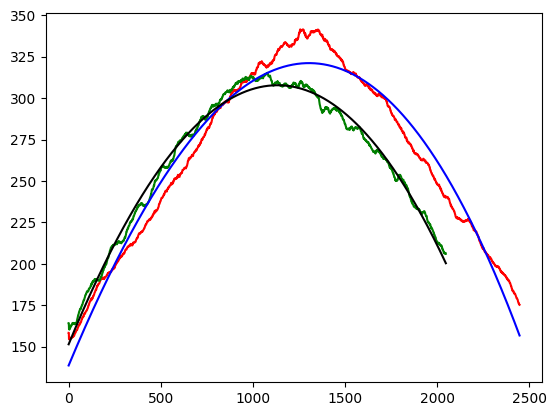

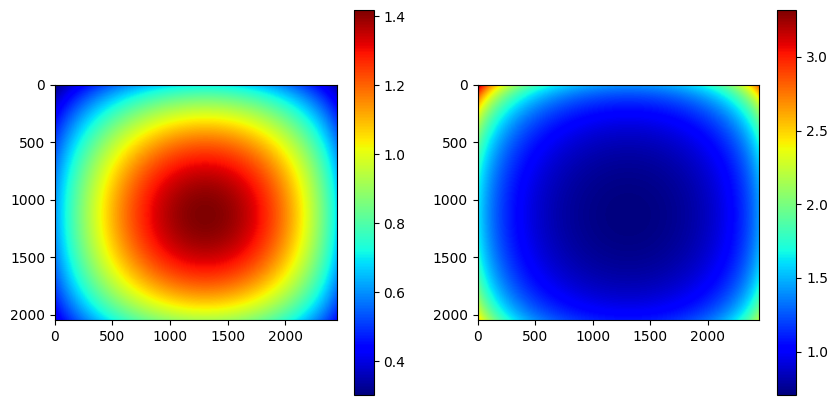

Hybe21_70 Strip21_66


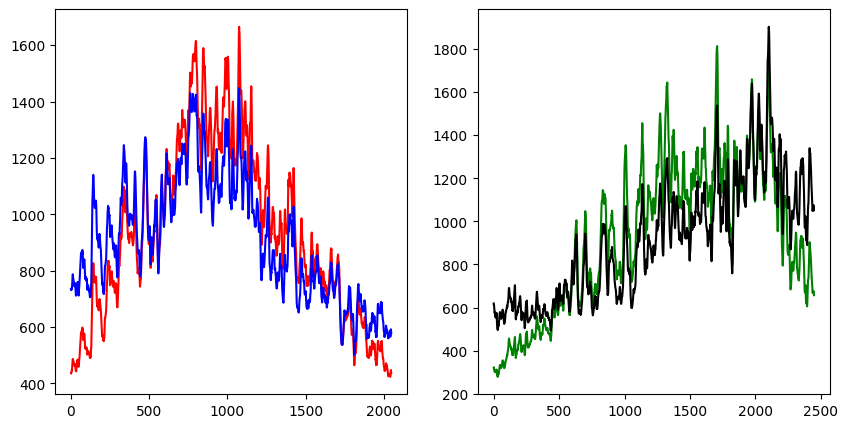

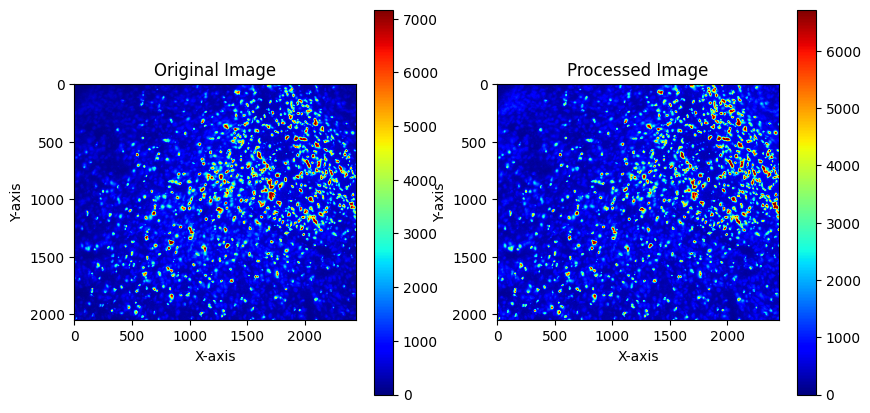

Hybe23_231 Strip23_226


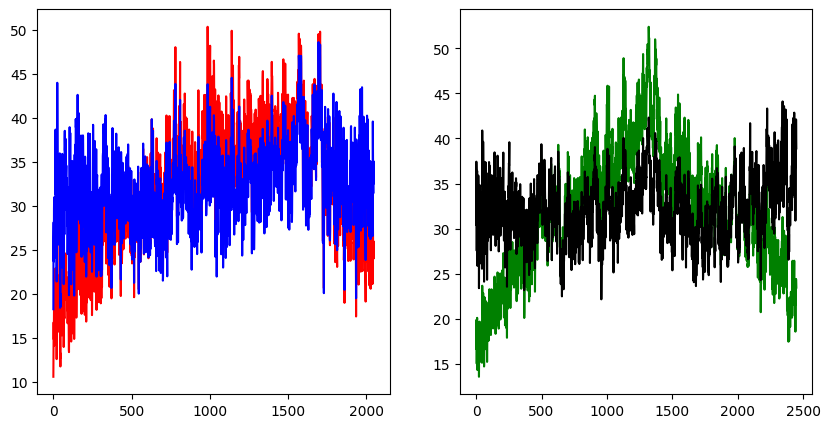

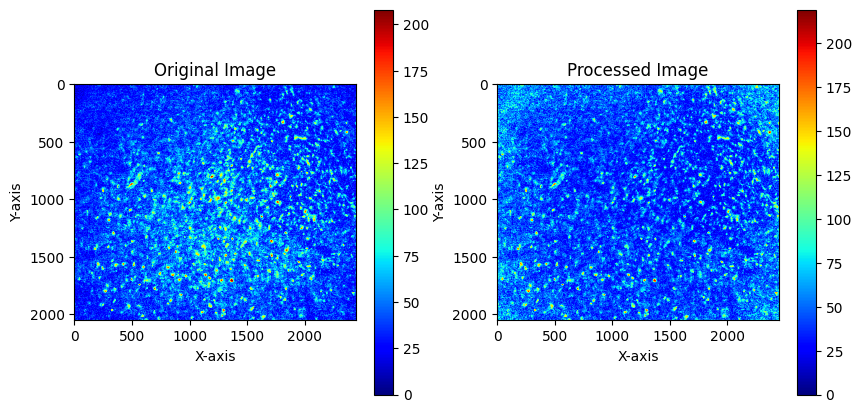

In [91]:
x = median_filter(np.mean(FF,axis=0),2)
y = median_filter(np.mean(FF,axis=1),2)
raw_x = x.copy()
raw_y = y.copy()
plt.plot(range(x.shape[0]),x,c='r')
plt.plot(range(y.shape[0]),y,c='g')
x_sum = x.sum()
y_sum = y.sum()
try:
    x = np.poly1d(np.polyfit(range(x.shape[0]), x, 3))(range(x.shape[0]))
    y = np.poly1d(np.polyfit(range(y.shape[0]), y, 3))(range(y.shape[0]))
    plt.plot(range(x.shape[0]),x,c='b')
    plt.plot(range(y.shape[0]),y,c='k')
    fit_FF = ((np.ones_like(FF)*x)*(np.ones_like(FF).T*y).T)
    fit_FF = fit_FF/np.median(fit_FF)
except Exception as e:
    print(e)
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im = axs[0].imshow(fit_FF,cmap='jet')
plt.colorbar(im,ax=axs[0])
im=axs[1].imshow(1/fit_FF,cmap='jet')
plt.colorbar(im,ax=axs[1])
plt.show()

for acq,bkg_acq in [['Hybe21_70','Strip21_66'],['Hybe23_231','Strip23_226']]:
    print(acq,bkg_acq)
    img = image_metadata.stkread(Position=posnames[30],Channel=channel,acq=acq).min(2).astype(float)
    img = median_filter(img,2)
    bkg = image_metadata.stkread(Position=posnames[30],Channel=channel,acq=bkg_acq).min(2).astype(float)
    bkg = median_filter(bkg,2)
    img = img-bkg

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(range(img.shape[0]), np.mean(img, axis=1), c='r')
    axs[0].plot(range(img.shape[0]), np.mean(np.median(fit_FF) * img / fit_FF, axis=1), c='b')

    axs[1].plot(range(img.shape[1]), np.mean(img, axis=0), c='g')
    axs[1].plot(range(img.shape[1]), np.mean(np.median(fit_FF) * img / fit_FF, axis=0), c='k')

    plt.show()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    vmin,vmax = np.percentile(img.ravel(),[1,99])
    im = axs[0].imshow(np.clip(img,0,vmax),cmap='jet')
    axs[0].set_title('Original Image')
    axs[0].set_xlabel('X-axis')
    axs[0].set_ylabel('Y-axis')
    plt.colorbar(im, ax=axs[0])  # Adding colorbar to the plot

    img = np.median(fit_FF)*img/fit_FF
    vmin,vmax = np.percentile(img.ravel(),[1,99])
    im = axs[1].imshow(np.clip(img,0,vmax),cmap='jet')
    axs[1].set_title('Processed Image')
    axs[1].set_xlabel('X-axis')
    axs[1].set_ylabel('Y-axis')
    plt.colorbar(im, ax=axs[1]) 

    plt.show()
